<a href="https://colab.research.google.com/github/WinetraubLab/3D-segmentation/blob/05-02/3D-segmentation.ipynb" target="_blank">
<img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab"/></a>
<a href="https://github.com/WinetraubLab/3D-segmentation/blob/05-02/3D-segmentation.ipynb" target="_blank">
  <img src="https://img.shields.io/badge/view%20in-GitHub-blue" alt="View in GitHub"/>
</a>

#   Segmentation with MedSAM2
Use MedSAM2 to segment a stack of OCT images.

In [ ]:
# @title Run this cell first, then click "Restart session" when prompted.
!pip install hydra-core

In [ ]:
# @title Other installations
!pip install SimpleITK
!pip install roboflow
!pip install iopath
!git clone https://github.com/bowang-lab/MedSAM2.git
!pip install torch torchvision
%cd MedSAM2
!sh download.sh

In [3]:
# @title Load Roboflow Data
from pycocotools.coco import COCO
from pycocotools import mask as mask_utils
from roboflow import Roboflow
import os

# LOAD ROBOFLOW DATA
your_api_key = "eg80ffVAjXnxLl7WKoav"  # @param {type:"string"}
# user can set their own API key?
os.environ["ROBOFLOW_API_KEY"] = your_api_key

rf = Roboflow(api_key=os.environ.get("ROBOFLOW_API_KEY"))
project = rf.workspace("yolab-kmmfx").project("vol1_2")

# Automatically download the latest version
versions = project.versions()
latest_version = max(versions, key=lambda v: v.version)
dataset = latest_version.download("coco-segmentation")

# Set global paths
DS_BASE_PATH = dataset.location
VIDEO_DIR = f"{DS_BASE_PATH}/clahe/"
VIDEO_NAME = ""
OUTPUT_DIR = f"{DS_BASE_PATH}/output/"
COCO_PATH = f"{DS_BASE_PATH}/test/_annotations.coco.json"

MODEL_CONFIG = "configs/sam2.1_hiera_t512.yaml"
MODEL_CHECKPOINT = "checkpoints/MedSAM2_latest.pt"

FORWARD_OUTDIR = f"{DS_BASE_PATH}/out_forwards/"
BACKWARD_OUTDIR = f"{DS_BASE_PATH}/out_backwards/"
os.makedirs(os.path.join(FORWARD_OUTDIR, VIDEO_NAME), exist_ok=True)
os.makedirs(os.path.join(BACKWARD_OUTDIR, VIDEO_NAME), exist_ok=True)

loading Roboflow workspace...
loading Roboflow project...


In [4]:
# @title Helper Functions

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sam2.build_sam import build_sam2_video_predictor
import torch
import json
from collections import defaultdict

import shutil
from google.colab import files

DAVIS_PALETTE = b"\x00\x00\x00\x80\x00\x00\x00\x80\x00\x80\x80\x00\x00\x00\x80\x80\x00\x80\x00\x80\x80\x80\x80\x80@\x00\x00\xc0\x00\x00@\x80\x00\xc0\x80\x00@\x00\x80\xc0\x00\x80@\x80\x80\xc0\x80\x80\x00@\x00\x80@\x00\x00\xc0\x00\x80\xc0\x00\x00@\x80\x80@\x80\x00\xc0\x80\x80\xc0\x80@@\x00\xc0@\x00@\xc0\x00\xc0\xc0\x00@@\x80\xc0@\x80@\xc0\x80\xc0\xc0\x80\x00\x00@\x80\x00@\x00\x80@\x80\x80@\x00\x00\xc0\x80\x00\xc0\x00\x80\xc0\x80\x80\xc0@\x00@\xc0\x00@@\x80@\xc0\x80@@\x00\xc0\xc0\x00\xc0@\x80\xc0\xc0\x80\xc0\x00@@\x80@@\x00\xc0@\x80\xc0@\x00@\xc0\x80@\xc0\x00\xc0\xc0\x80\xc0\xc0@@@\xc0@@@\xc0@\xc0\xc0@@@\xc0\xc0@\xc0@\xc0\xc0\xc0\xc0\xc0 \x00\x00\xa0\x00\x00 \x80\x00\xa0\x80\x00 \x00\x80\xa0\x00\x80 \x80\x80\xa0\x80\x80`\x00\x00\xe0\x00\x00`\x80\x00\xe0\x80\x00`\x00\x80\xe0\x00\x80`\x80\x80\xe0\x80\x80 @\x00\xa0@\x00 \xc0\x00\xa0\xc0\x00 @\x80\xa0@\x80 \xc0\x80\xa0\xc0\x80`@\x00\xe0@\x00`\xc0\x00\xe0\xc0\x00`@\x80\xe0@\x80`\xc0\x80\xe0\xc0\x80 \x00@\xa0\x00@ \x80@\xa0\x80@ \x00\xc0\xa0\x00\xc0 \x80\xc0\xa0\x80\xc0`\x00@\xe0\x00@`\x80@\xe0\x80@`\x00\xc0\xe0\x00\xc0`\x80\xc0\xe0\x80\xc0 @@\xa0@@ \xc0@\xa0\xc0@ @\xc0\xa0@\xc0 \xc0\xc0\xa0\xc0\xc0`@@\xe0@@`\xc0@\xe0\xc0@`@\xc0\xe0@\xc0`\xc0\xc0\xe0\xc0\xc0\x00 \x00\x80 \x00\x00\xa0\x00\x80\xa0\x00\x00 \x80\x80 \x80\x00\xa0\x80\x80\xa0\x80@ \x00\xc0 \x00@\xa0\x00\xc0\xa0\x00@ \x80\xc0 \x80@\xa0\x80\xc0\xa0\x80\x00`\x00\x80`\x00\x00\xe0\x00\x80\xe0\x00\x00`\x80\x80`\x80\x00\xe0\x80\x80\xe0\x80@`\x00\xc0`\x00@\xe0\x00\xc0\xe0\x00@`\x80\xc0`\x80@\xe0\x80\xc0\xe0\x80\x00 @\x80 @\x00\xa0@\x80\xa0@\x00 \xc0\x80 \xc0\x00\xa0\xc0\x80\xa0\xc0@ @\xc0 @@\xa0@\xc0\xa0@@ \xc0\xc0 \xc0@\xa0\xc0\xc0\xa0\xc0\x00`@\x80`@\x00\xe0@\x80\xe0@\x00`\xc0\x80`\xc0\x00\xe0\xc0\x80\xe0\xc0@`@\xc0`@@\xe0@\xc0\xe0@@`\xc0\xc0`\xc0@\xe0\xc0\xc0\xe0\xc0  \x00\xa0 \x00 \xa0\x00\xa0\xa0\x00  \x80\xa0 \x80 \xa0\x80\xa0\xa0\x80` \x00\xe0 \x00`\xa0\x00\xe0\xa0\x00` \x80\xe0 \x80`\xa0\x80\xe0\xa0\x80 `\x00\xa0`\x00 \xe0\x00\xa0\xe0\x00 `\x80\xa0`\x80 \xe0\x80\xa0\xe0\x80``\x00\xe0`\x00`\xe0\x00\xe0\xe0\x00``\x80\xe0`\x80`\xe0\x80\xe0\xe0\x80  @\xa0 @ \xa0@\xa0\xa0@  \xc0\xa0 \xc0 \xa0\xc0\xa0\xa0\xc0` @\xe0 @`\xa0@\xe0\xa0@` \xc0\xe0 \xc0`\xa0\xc0\xe0\xa0\xc0 `@\xa0`@ \xe0@\xa0\xe0@ `\xc0\xa0`\xc0 \xe0\xc0\xa0\xe0\xc0``@\xe0`@`\xe0@\xe0\xe0@``\xc0\xe0`\xc0`\xe0\xc0\xe0\xe0\xc0"

def load_ann_png(path):
    """Load a PNG file as a mask and its palette."""
    mask = Image.open(path)
    palette = mask.getpalette()
    mask = np.array(mask).astype(np.uint8)
    return mask, palette

def get_per_obj_mask(mask):
    """Split a mask into per-object masks."""
    object_ids = np.unique(mask)
    object_ids = object_ids[object_ids > 0].tolist()
    per_obj_mask = {object_id: (mask == object_id) for object_id in object_ids}
    return per_obj_mask

def put_per_obj_mask(per_obj_mask, height, width):
    """Combine per-object masks into a single mask."""
    mask = np.zeros((height, width), dtype=np.uint8)
    object_ids = sorted(per_obj_mask)[::-1]
    for object_id in object_ids:
        object_mask = per_obj_mask[object_id]
        object_mask = object_mask.reshape(height, width)
        mask[object_mask] = object_id
    return mask

def load_masks_from_dir(input_mask_path):
    input_mask, input_palette = load_ann_png(input_mask_path)
    per_obj_input_mask = get_per_obj_mask(input_mask)

    return per_obj_input_mask, input_palette

def save_predictions_to_dir(
    output_mask_dir,
    video_name,
    frame_name,
    per_obj_output_mask,
    height,
    width,
):
    """Save masks to a directory as PNG files."""
    os.makedirs(os.path.join(output_mask_dir, video_name), exist_ok=True)

    output_mask = put_per_obj_mask(per_obj_output_mask, height, width)
    output_mask_path = os.path.join(
        output_mask_dir, video_name, f"{frame_name}.png"
    )
    assert output_mask.dtype == np.uint8
    assert output_mask.ndim == 2
    output_mask = Image.fromarray(output_mask)
    output_mask.save(output_mask_path)

def save_clahe_images(input_path, clahe_path):
    # CLAHE normalization helps improve contrast for segmentation

    # Create output folder if it doesn't exist
    os.makedirs(clahe_path, exist_ok=True)

    for fn in os.listdir(input_path):
        if fn.lower().endswith('.jpg'):
            img = os.path.join(input_path, fn)

            output_path = os.path.join(clahe_path, fn)

            # Read the image
            image = cv2.imread(img)

            # Convert to LAB color space
            lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
            l, a, b = cv2.split(lab)

            # Apply CLAHE to the L-channel
            clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
            l_clahe = clahe.apply(l)

            # Merge the channels and convert back to BGR
            lab_clahe = cv2.merge((l_clahe, a, b))
            image_clahe = cv2.cvtColor(lab_clahe, cv2.COLOR_LAB2BGR)

            # Save the result
            cv2.imwrite(output_path, image_clahe)


In [5]:
# @title Convert COCO annotations to mask image
def create_mask_image(initial_mask_path, init_mask_idx, class_id):

    first_frame_name = frame_names[init_mask_idx] + ".jpg"
    os.makedirs(os.path.dirname(initial_mask_path), exist_ok=True)

    with open(COCO_PATH, 'r') as f:
        coco = json.load(f)

    image_id_map = {img["file_name"]: img["id"] for img in coco["images"]}
    image_info_map = {img["id"]: img for img in coco["images"]}
    first_image_id = image_id_map[first_frame_name]

    annotations_per_image = defaultdict(list)
    for ann in coco["annotations"]:
        annotations_per_image[ann["image_id"]].append(ann)

    file_name = first_frame_name
    if file_name not in image_id_map:
        print(f"Skipping frame {file_name}, not in COCO annotations.")

    image_id = image_id_map[file_name]
    image_info = image_info_map[image_id]
    height, width = image_info["height"], image_info["width"]

    # Create blank mask
    mask = np.zeros((height, width), dtype=np.uint8)

    obj_id = 200
    for ann in annotations_per_image[image_id]:
        if ann.get("iscrowd", 0):
            rle = mask_utils.frPyObjects([ann["segmentation"]], height, width)
            m = mask_utils.decode(rle[0])
        else:
            rle = mask_utils.frPyObjects(ann["segmentation"], height, width)
            m = mask_utils.decode(rle)
            if len(m.shape) == 3:
                m = np.any(m, axis=2).astype(np.uint8)

        if ann["category_id"] == class_id: # tumor
            mask[m.astype(bool)] = obj_id

    Image.fromarray(mask).save(initial_mask_path)
    plt.imshow(mask)
    plt.show()

    # print(f"Saved mask for {first_frame_name} with {obj_id - 1} object(s)")
    print(f"Unique values in mask: {np.unique(mask)}")

In [6]:
# @title Prepare input masks for prompting

def add_input_masks_from_keyframe(init_mask_idx, initial_mask_path):
    """ init_mask_idx: index of the mask file """

    # Add input masks to MedSAM2 inference state before propagation
    object_ids_set = None
    input_frame_idx = init_mask_idx  # use first frame as mask input
    try:
        per_obj_input_mask, input_palette = load_masks_from_dir(input_mask_path=initial_mask_path)
    except FileNotFoundError as e:
        raise RuntimeError(
            f"In {VIDEO_NAME=}, failed to load input mask for frame {input_frame_idx=}. "
            "Please add the `--track_object_appearing_later_in_video` flag "
            "for VOS datasets that don't have all objects to track appearing "
            "in the first frame (such as LVOS or YouTube-VOS)."
        ) from e

    # get the list of object ids to track from the first input frame
    if object_ids_set is None:
        object_ids_set = set(per_obj_input_mask)
    for object_id, object_mask in per_obj_input_mask.items():
        # check and make sure no new object ids appear only in later frames
        if object_id not in object_ids_set:
            print(f"WARNING: in {VIDEO_NAME=}, got no object ids on {input_frame_idx=}.")
        predictor.add_new_mask(
            inference_state=inference_state,
            frame_idx=input_frame_idx,
            obj_id=object_id,
            mask=object_mask,
                )

    # check and make sure we have at least one object to track
    if object_ids_set is None or len(object_ids_set) == 0:
        print(f"WARNING: in {VIDEO_NAME=}, got no object ids on {input_frame_idx=}.")

    return object_ids_set


In [7]:
# @title Bidirectional Inference
def run_bidirectional_inference_between_pairs(predictor, inference_state, pair_indices, class_id, forwards=True, backwards=True):
    start_idx, end_idx = pair_indices

    video_segments_f = {}
    video_segments_b = {}
    video_logits_f = {}
    video_logits_b = {}

    inference_state = predictor.init_state(
    video_path=os.path.join(VIDEO_DIR, VIDEO_NAME), async_loading_frames=False)

    height = inference_state["video_height"]
    width = inference_state["video_width"]

    print(f"\n=== FORWARD from frame {start_idx} to {end_idx} ===")

    create_mask_image(f"{DS_BASE_PATH}/output_masks_class_{class_id}/" + frame_names[start_idx] + ".png", start_idx, class_id)
    per_obj_input_mask, input_palette = load_masks_from_dir(f"{DS_BASE_PATH}/output_masks_class_{class_id}/" + frame_names[start_idx] + ".png")

    for object_id, object_mask in per_obj_input_mask.items():
        # print(object_id)
        predictor.add_new_mask(
            inference_state=inference_state,
            frame_idx=start_idx,
            obj_id=object_id,
            mask=object_mask,
                )

    # if no objects, don't run in this direction
    if len(per_obj_input_mask) == 0:
        forwards = False

    if forwards:

        for out_frame_idx, out_obj_ids, out_mask_logits in predictor.propagate_in_video(inference_state, start_frame_idx=start_idx,
            max_frame_num_to_track=end_idx-start_idx):
            # Get binary masks
            per_obj_output_mask = {
                out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy()
                for i, out_obj_id in enumerate(out_obj_ids)
            }

            # Save segmentation
            video_segments_f[out_frame_idx] = per_obj_output_mask

            # Store logits
            video_logits_f[out_frame_idx] = {
                out_obj_id: out_mask_logits[i].cpu()
                for i, out_obj_id in enumerate(out_obj_ids)
            }

            # Save masks to disk
            save_predictions_to_dir(
                output_mask_dir=FORWARD_OUTDIR,
                video_name=VIDEO_NAME,
                frame_name=frame_names[out_frame_idx],
                per_obj_output_mask=per_obj_output_mask,
                height=height,
                width=width,
            )

            # Feed each predicted mask as prompt for the next frame
            next_frame_idx = out_frame_idx + 1
            if next_frame_idx < end_idx:
                for obj_id, mask in per_obj_output_mask.items():
                    if mask is not None and np.any(mask):
                        predictor.add_new_mask(
                            inference_state=inference_state,
                            frame_idx=next_frame_idx,
                            obj_id=obj_id,
                            mask=mask.squeeze(),
                        )

    # Reinitialize for backwards pass
    inference_state = predictor.init_state(
    video_path=os.path.join(VIDEO_DIR, VIDEO_NAME), async_loading_frames=False)

    print(f"\n=== BACKWARD from frame {end_idx} to {start_idx} ===")

    create_mask_image(f"{DS_BASE_PATH}/output_masks_class_{class_id}/" + frame_names[end_idx] + ".png", end_idx, class_id)
    per_obj_input_mask, input_palette = load_masks_from_dir(f"{DS_BASE_PATH}/output_masks_class_{class_id}/" + frame_names[end_idx] + ".png")
    for object_id, object_mask in per_obj_input_mask.items():
        predictor.add_new_mask(
            inference_state=inference_state,
            frame_idx=end_idx,
            obj_id=object_id,
            mask=object_mask.squeeze(),
            )

    # if no objects, don't run in this direction
    if len(per_obj_input_mask) == 0:
        backwards = False

    if backwards:
        for out_frame_idx, out_obj_ids, out_mask_logits in predictor.propagate_in_video(inference_state, start_frame_idx=end_idx,
            max_frame_num_to_track=end_idx-start_idx, reverse=True):
            # Get binary masks
            per_obj_output_mask = {
                out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy()
                for i, out_obj_id in enumerate(out_obj_ids)
            }

            # Save segmentation
            video_segments_b[out_frame_idx] = per_obj_output_mask

            # Store logits
            video_logits_b[out_frame_idx] = {
                out_obj_id: out_mask_logits[i].cpu()
                for i, out_obj_id in enumerate(out_obj_ids)
            }

            height = inference_state["video_height"]
            width = inference_state["video_width"]

            # Save masks to disk
            save_predictions_to_dir(
                output_mask_dir=BACKWARD_OUTDIR,
                video_name=VIDEO_NAME,
                frame_name=frame_names[out_frame_idx],
                per_obj_output_mask=per_obj_output_mask,
                height=height,
                width=width,
            )

            # Feed each predicted mask as a prompt for the next frame
            next_frame_idx = out_frame_idx - 1

            if next_frame_idx > start_idx:
                for obj_id, mask in per_obj_output_mask.items():
                    if mask is not None and np.any(mask):
                        predictor.add_new_mask(
                            inference_state=inference_state,
                            frame_idx=next_frame_idx,
                            obj_id=obj_id,
                            mask=mask.squeeze(),
                        )
    return video_segments_f, video_segments_b, video_logits_f, video_logits_b, input_palette

In [8]:
# @title Reconcile Forward/Backward Masks
from torch.nn.functional import sigmoid

def merge_bidirectional_masks(keyframe_indices, video_logits_f, video_logits_b, thresh=0.5):

    fused_masks = {}

    for t in range(keyframe_indices[0], keyframe_indices[1] + 1):
        if t in video_logits_f and t in video_logits_b:
            # print(f"Merging masks for frame {t}")
            frame_logits_f = video_logits_f[t]
            frame_logits_b = video_logits_b[t]
            fused_masks[t] = {}

            for obj_id in frame_logits_f.keys():
                if obj_id in frame_logits_b:
                    logit_f = frame_logits_f[obj_id]
                    logit_b = frame_logits_b[obj_id]

                    # Distance-weighted fusion: favor closer keyframe
                    alpha = (keyframe_indices[1] - t) / (keyframe_indices[1] - keyframe_indices[0])
                    fused_logit = alpha * logit_f + (1 - alpha) * logit_b

                    # Apply sigmoid to get probabilities
                    prob = sigmoid(fused_logit)

                    # Threshold to bool
                    mask = (prob > thresh).bool().numpy()

                    fused_masks[t][obj_id] = mask
        elif t in video_logits_f:
            print(f"Using forward masks for frame {t}")
            if t not in fused_masks:
                fused_masks[t] = {}
            for obj_id, logit in video_logits_f[t].items():
                fused_masks[t][obj_id] = (sigmoid(logit) > thresh).bool().numpy()
        elif t in video_logits_b:
            print(f"Using backward masks for frame {t}")
            if t not in fused_masks:
                fused_masks[t] = {}
            for obj_id, logit in video_logits_b[t].items():
                fused_masks[t][obj_id] = (sigmoid(logit) > thresh).bool().numpy()
        else:
            print(f"No masks found for frame {t}")

    return fused_masks


Total number of unique classes: 3


Flash Attention is disabled as it requires a GPU with Ampere (8.0) CUDA capability.
frame loading (JPEG): 100%|██████████| 4/4 [00:00<00:00, 43.77it/s]


Evaluating pair:  [0, 1]


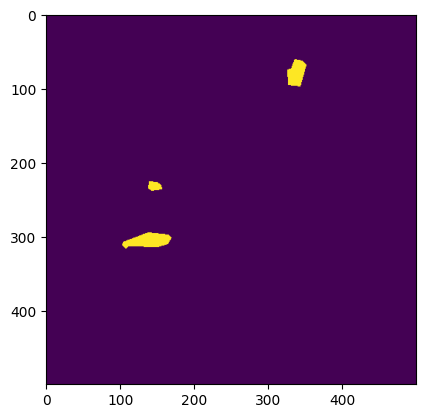

Unique values in mask: [  0 200]


Python version mismatch: module was compiled for Python 3.12, but the interpreter version is incompatible: 3.11.12 (main, Apr  9 2025, 08:55:54) [GCC 11.4.0].

Skipping the post-processing step due to the error above. You can still use SAM 2 and it's OK to ignore the error above, although some post-processing functionality may be limited (which doesn't affect the results in most cases; see https://github.com/facebookresearch/sam2/blob/main/INSTALL.md).
frame loading (JPEG): 100%|██████████| 4/4 [00:00<00:00, 59.90it/s]



=== FORWARD from frame 0 to 1 ===


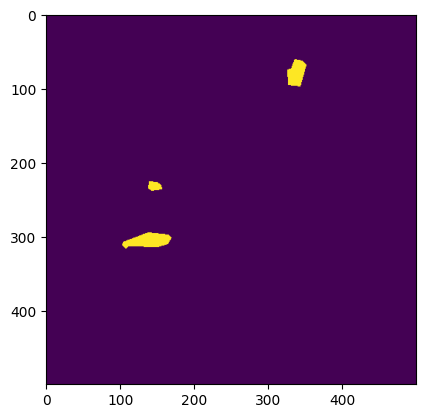

Unique values in mask: [  0 200]


frame loading (JPEG): 100%|██████████| 4/4 [00:00<00:00, 57.87it/s]



=== BACKWARD from frame 1 to 0 ===


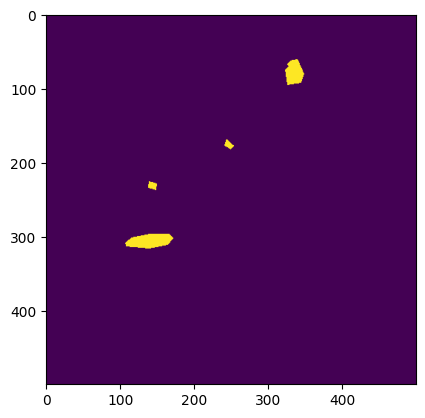

Unique values in mask: [  0 200]


frame loading (JPEG): 100%|██████████| 4/4 [00:00<00:00, 23.99it/s]


Evaluating pair:  [1, 2]


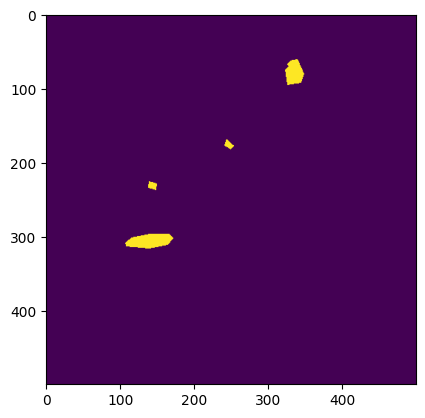

Unique values in mask: [  0 200]


frame loading (JPEG): 100%|██████████| 4/4 [00:00<00:00, 65.33it/s]



=== FORWARD from frame 1 to 2 ===


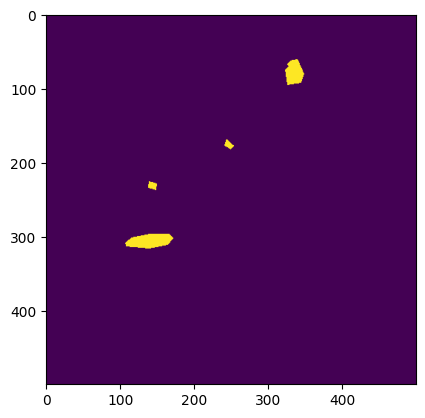

Unique values in mask: [  0 200]


frame loading (JPEG): 100%|██████████| 4/4 [00:00<00:00, 101.03it/s]



=== BACKWARD from frame 2 to 1 ===


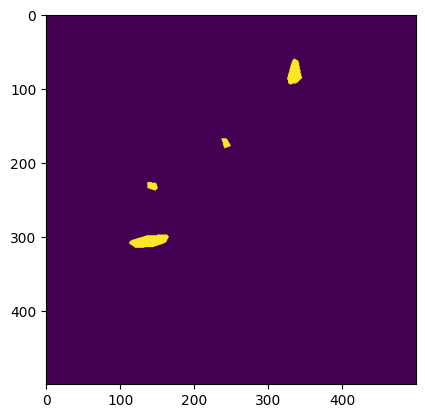

Unique values in mask: [  0 200]


frame loading (JPEG): 100%|██████████| 4/4 [00:00<00:00, 102.31it/s]

Evaluating pair:  [2, 3]


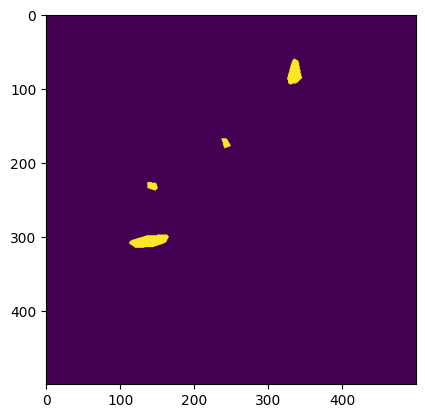

Unique values in mask: [  0 200]


frame loading (JPEG): 100%|██████████| 4/4 [00:00<00:00, 102.48it/s]


=== FORWARD from frame 2 to 3 ===


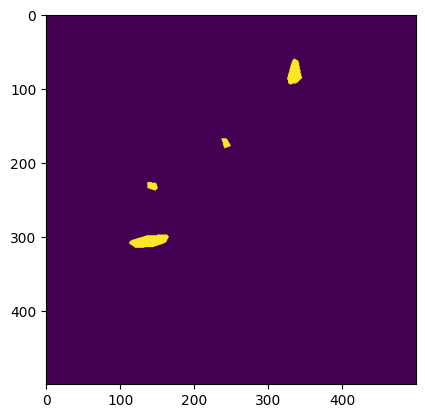

Unique values in mask: [  0 200]


frame loading (JPEG): 100%|██████████| 4/4 [00:00<00:00, 54.19it/s]



=== BACKWARD from frame 3 to 2 ===


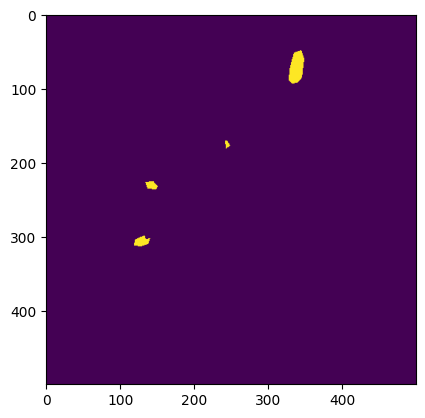

Unique values in mask: [  0 200]


frame loading (JPEG): 100%|██████████| 4/4 [00:00<00:00, 96.82it/s]


Evaluating pair:  [0, 1]


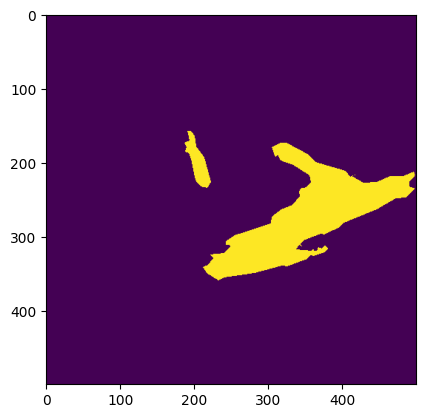

Unique values in mask: [  0 200]


frame loading (JPEG): 100%|██████████| 4/4 [00:00<00:00, 82.41it/s]


=== FORWARD from frame 0 to 1 ===


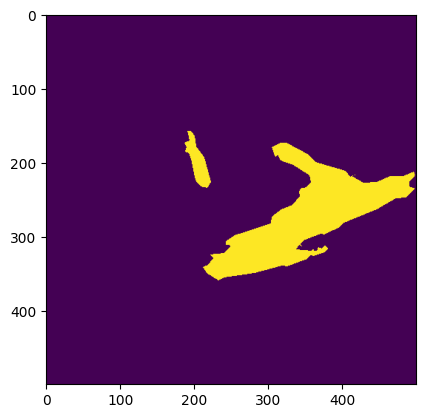

Unique values in mask: [  0 200]


frame loading (JPEG): 100%|██████████| 4/4 [00:00<00:00, 96.04it/s]


=== BACKWARD from frame 1 to 0 ===


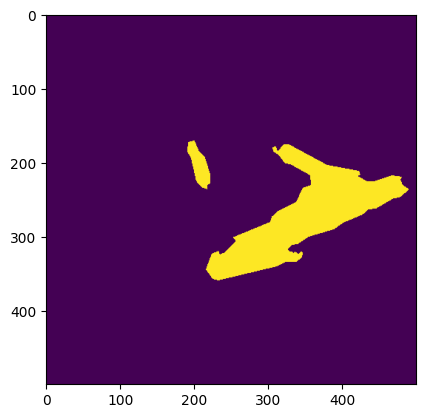

Unique values in mask: [  0 200]


frame loading (JPEG): 100%|██████████| 4/4 [00:00<00:00, 96.57it/s]


Evaluating pair:  [1, 2]


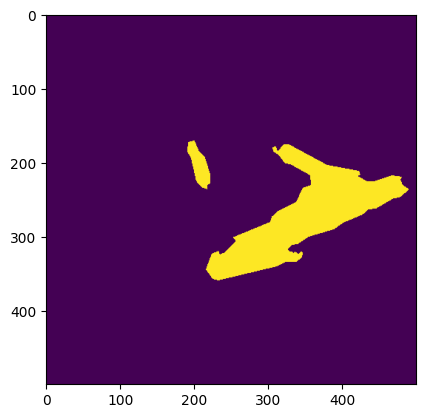

Unique values in mask: [  0 200]


frame loading (JPEG): 100%|██████████| 4/4 [00:00<00:00, 101.49it/s]


=== FORWARD from frame 1 to 2 ===


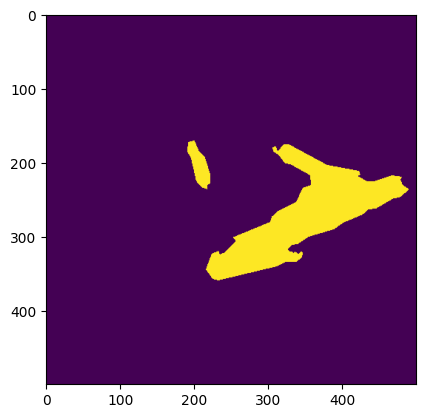

Unique values in mask: [  0 200]


frame loading (JPEG): 100%|██████████| 4/4 [00:00<00:00, 98.07it/s]


=== BACKWARD from frame 2 to 1 ===


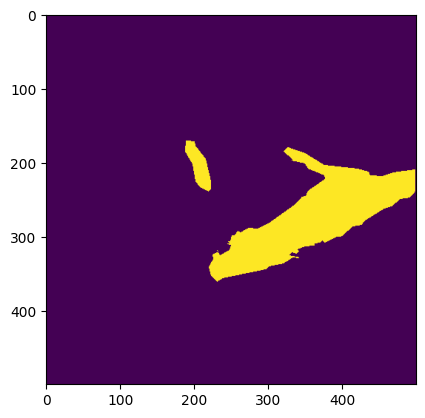

Unique values in mask: [  0 200]


frame loading (JPEG): 100%|██████████| 4/4 [00:00<00:00, 99.56it/s]

Evaluating pair:  [2, 3]


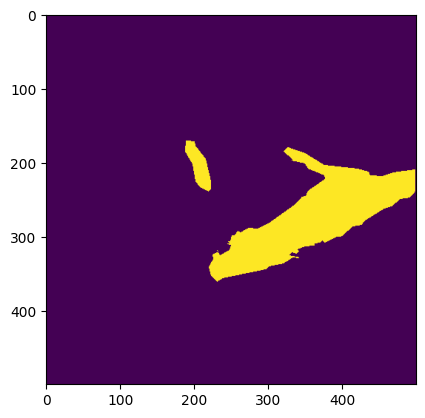

Unique values in mask: [  0 200]


frame loading (JPEG): 100%|██████████| 4/4 [00:00<00:00, 95.94it/s]


=== FORWARD from frame 2 to 3 ===


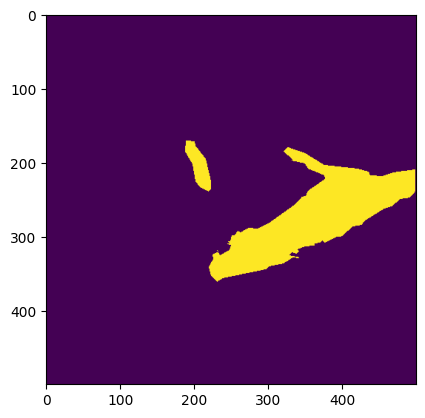

Unique values in mask: [  0 200]


frame loading (JPEG): 100%|██████████| 4/4 [00:00<00:00, 78.24it/s]


=== BACKWARD from frame 3 to 2 ===


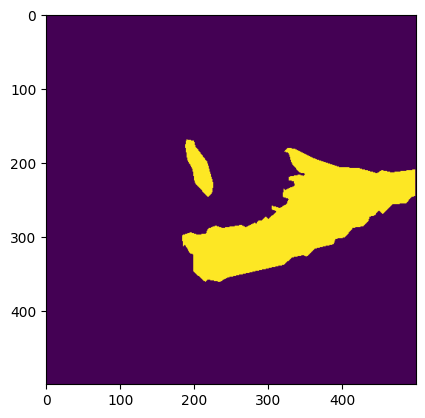

Unique values in mask: [  0 200]


frame loading (JPEG): 100%|██████████| 4/4 [00:00<00:00, 98.74it/s]


Evaluating pair:  [0, 3]


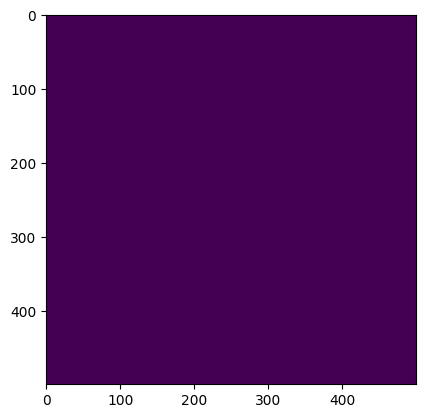

Unique values in mask: [0]


frame loading (JPEG): 100%|██████████| 4/4 [00:00<00:00, 93.74it/s]


=== FORWARD from frame 0 to 3 ===


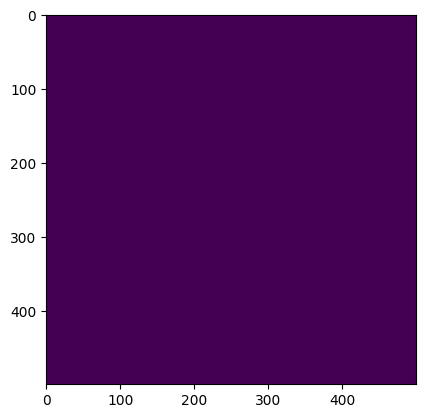

Unique values in mask: [0]


frame loading (JPEG): 100%|██████████| 4/4 [00:00<00:00, 90.10it/s]


=== BACKWARD from frame 3 to 0 ===


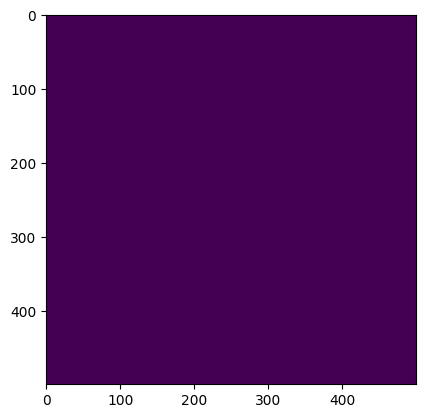

Unique values in mask: [0]
No masks found for frame 0
No masks found for frame 1
No masks found for frame 2
No masks found for frame 3


In [9]:
# @title Run model for series of keyframes

# CLAHE equalization
orig_images_path = f"{DS_BASE_PATH}/test/"
save_clahe_images(orig_images_path, VIDEO_DIR)


# load the video frames
frame_names = [
        os.path.splitext(p)[0]
        for p in os.listdir(os.path.join(VIDEO_DIR, VIDEO_NAME))
        if os.path.splitext(p)[-1] in [".jpg", ".jpeg", ".JPG", ".JPEG"]
    ]
frame_names = list(sorted(frame_names))

with open(COCO_PATH, 'r') as f:
    coco = json.load(f)

# Get all category_ids
category_ids = {ann['category_id'] for ann in coco['annotations']}

# Count unique classes
num_classes = len(category_ids)

print(f"Total number of unique classes: {num_classes}")

for class_id in category_ids:
    ann_ids = sorted(list({ann["image_id"] for ann in coco["annotations"] if ann['category_id'] == class_id}))

    keyframe_filenames = [
        img['file_name'].split(".")[0] if 'file_name' in img else img['name']
        for img in coco['images']
        if img['id'] in ann_ids
    ]

    keyframe_indices = {0, len(frame_names)-1}
    for ann in keyframe_filenames:
        for i, name in enumerate(frame_names):
            if ann in name:
                keyframe_indices.add(i)

    keyframe_indices = sorted(list(keyframe_indices))

    for i in range(len(keyframe_indices)-1):

        # Initialize predictor
        predictor = build_sam2_video_predictor(
            config_file=MODEL_CONFIG,
            ckpt_path=MODEL_CHECKPOINT,
            apply_postprocessing=True,
            # hydra_overrides_extra=hydra_overrides_extra,
            vos_optimized=  True,
        )
        inference_state = predictor.init_state(video_path=os.path.join(VIDEO_DIR, VIDEO_NAME), async_loading_frames=False)

        kf_pair = [keyframe_indices[i], keyframe_indices[i+1]]
        print("Evaluating pair: ", kf_pair)

        matching_frame_name = next((name for name in frame_names if keyframe_filenames[i] in name), None)
        initial_mask_path = f"{DS_BASE_PATH}/output_masks_class_{class_id}/{matching_frame_name}.png"

        # Create masks from COCO
        mask = create_mask_image(initial_mask_path, kf_pair[0], class_id)
        add_input_masks_from_keyframe(kf_pair[0], initial_mask_path)

        video_segments_f, video_segments_b, video_logits_f, video_logits_b, input_palette = run_bidirectional_inference_between_pairs(predictor, inference_state, kf_pair, class_id)

        fused_masks = merge_bidirectional_masks(kf_pair, video_logits_f, video_logits_b)

        height = inference_state["video_height"]
        width = inference_state["video_width"]

        for t, obj_masks in fused_masks.items():
                save_predictions_to_dir(
                    output_mask_dir=f"{DS_BASE_PATH}/merged_predictions_class_{class_id}/",
                    video_name=VIDEO_NAME,
                    frame_name=frame_names[t],
                    per_obj_output_mask=obj_masks,
                    height=height,
                    width=width,
                )


In [10]:
# @title Download individual class segmentations

## Change c, uncomment the below code in the cell, and run this code cell to download individual class segmentation

# c = 1  # c = class number
# folder_path = f"DS_BASE_PATH/merged_predictions_class_{c}/"  # change this to your folder path
# zip_path = f"/content/merged_predictions_class_{c}.zip"

# Zip the folder
# shutil.make_archive(zip_path.replace('.zip', ''), 'zip', folder_path)

# files.download(zip_path)


Skipping class 3 — directory not found: /content/MedSAM2/vol1_2-2/merged_predictions_class_3


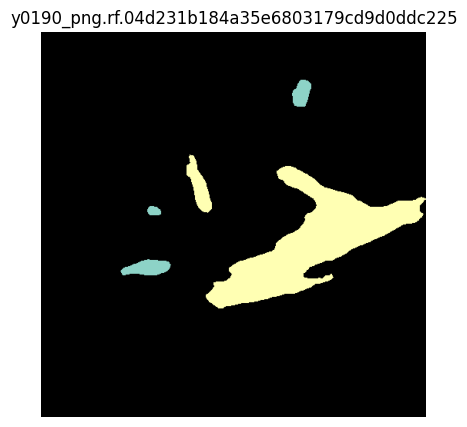

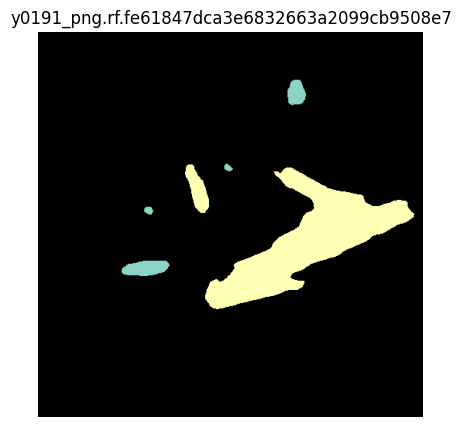

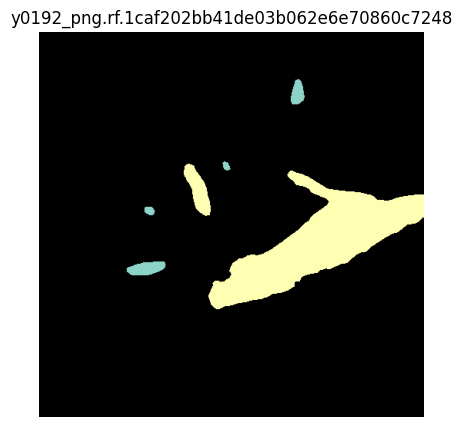

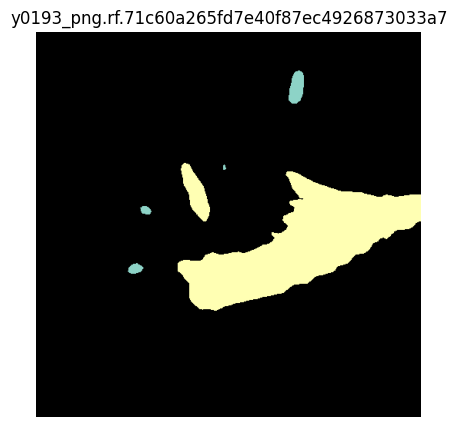

In [22]:
# @title Combine class masks

def get_file_map(directory):
    file_map = defaultdict(list)
    for fname in os.listdir(directory):
        name, ext = os.path.splitext(fname)
        file_map[name].append(os.path.join(directory, fname))
    return file_map

def combine_class_masks(mask_dirs, exclude_ranges=None, output_dir=None, show=True):
    if exclude_ranges is None:
        exclude_ranges = [["none", "none"] for _ in mask_dirs]

    os.makedirs(output_dir, exist_ok=True) if output_dir else None
    mask_maps = []



    for i, mask_dir in enumerate(mask_dirs):
        if not os.path.exists(mask_dir):
            print(f"Skipping class {i+1} — directory not found: {mask_dir}")
            mask_maps.append({})
            continue

        mask_maps.append(get_file_map(mask_dir))

    shared_keys = set(mask_maps[0].keys())
    for d in mask_maps[1:]:
        shared_keys = sorted(set().union(*[d.keys() for d in mask_maps if d]))

    for base_name in shared_keys:
        masks = []
        bins = []
        try:
            number = int(base_name[1:5])
        except ValueError:
            print(f"Skipping invalid file name: {base_name}")
            continue

        for i in range(len(mask_dirs)):
            exclude = False
            start, end = exclude_ranges[i]
            if start != "none" and end != "none":
                if int(start) <= number <= int(end):
                    exclude = True

            if exclude:
                print(f"Excluding {base_name} for class {i}")
                # Create empty mask
                file_path = next(iter(mask_maps[i].values()))[0]
                empty_mask = np.zeros_like(cv2.imread(file_path, cv2.IMREAD_GRAYSCALE))
                masks.append(empty_mask)
            elif base_name in mask_maps[i]:
                masks.append(cv2.imread(mask_maps[i][base_name][0], cv2.IMREAD_GRAYSCALE))
            else:
                ref_mask = masks[0] if masks else np.zeros((256, 256), dtype=np.uint8)  # empty if mask doesn't exist
                masks.append(np.zeros_like(ref_mask))

        for i in range(len(masks)):
            # Binarize masks
            bins.append((masks[i] > 0).astype(np.uint8))

        # Resolve conflicts: first class takes priority
        for i in range(len(bins)-1, 0, -1):
            bins[i][bins[i-1] == 1] = 0

        h, w = bins[0].shape
        rgb_mask = np.zeros((h, w, 3), dtype=np.uint8)

        num_classes = len(bins)
        cmap = plt.get_cmap('Set3')
        colors = (np.array([cmap(i)[:3] for i in range(num_classes)]) * 255).astype(np.uint8)

        for class_idx, binary_mask in enumerate(bins):
            color = colors[class_idx]
            rgb_mask[binary_mask == 1] = color

        if output_dir:
            out_path = os.path.join(output_dir, base_name + '.png')
            cv2.imwrite(out_path, cv2.cvtColor(rgb_mask, cv2.COLOR_RGB2BGR))

        if show:
            plt.figure(figsize=(5, 5))
            plt.imshow(rgb_mask)
            plt.title(base_name)
            plt.axis('off')
            plt.show()


mask_dirs = [f'{DS_BASE_PATH}/merged_predictions_class_{class_id}' for class_id in category_ids]
output_dir = '/content/final_merged'

# combine_class_masks(mask_dirs, [["none","none"], ["0064", "0068"], ["0178","0240"]], output_dir=output_dir, show=True)
combine_class_masks(mask_dirs, None, output_dir=output_dir, show=True)


In [19]:
import shutil
from google.colab import files

folder_path = '/content/final_merged'
zip_path = "/content/final_merged_segmentations.zip"

# Zip the folder
shutil.make_archive(zip_path.replace('.zip', ''), 'zip', folder_path)

# Download the zip file
files.download(zip_path)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>